# Сравнение DEAP, pymoo, GOLEM

**Постановка задачи:** поиск целевого графа по заданным метрикам. В качестве целевого графа рассматривается дерево (соотвественно исключаются изолированные вершины). Дерево выбрано для удобства.

## Пространство поиска
В DEAP, pymoo нельзя задать варьируемое число переменных. Поэтому для них можно сравнить только задачи при фиксированном числе переменных. Но чтобы просимулировать поиск размерности графа применился следующий трюк:
 
 - Пространство поиска задаётся матрицей смежности с размерностью = максимально возможное число вершин
 - Целевой граф задаётся с числом вершин 3/4 от максимально возможного
 - Исходная популяция состоит из графов с числом вершин 1/4 от максимально возможного

Таким образом рассматриваются задачи:
 - problem 1 (60, 45, 15)
 - problem 2 (80, 60, 20)
 - problem 3 (100, 75, 25)

В таком случае pymoo и deap производят поиск по числу вершин, а не только по рёбрам

## Конфигурация DEAP, pymoo
Рассматривается NSGA2 реализация.
- deap https://github.com/DEAP/deap/blob/master/examples/ga/nsga2.py
- pymoo https://pymoo.org/algorithms/moo/nsga2.html

Параметры алгоритма брались из оригинальной статьи:
 - single-point crossover ($p_c = 0.9$)
 - bitwise mutation ($p_m = 1 / n$, $n$ - размерность кодированного вектора)
 - population size - 100

В качестве кодирования графа использовалась матрица смежности. Для соблюдения условия исключения изолированных вершин и пространства поиска: если столбец матрицы и соответсвующая ему строка пусты - данная вершина на учитывается (по умолчанию считалась бы изолированной).

## Конфигурация GOLEM
- min_arity = 1 (т.к. ищём дерево)
- max_arity = search_space_size (максимально возможное число вершин)
- max_depth=search_space_size (максимально возможное число вершин)
- early_stopping_iterations=None (поиск по ограничению в число генераций)
- keep_n_best=4 
- timeout=None (поиск по ограничению в число генераций)
- num_of_generations=generations_limit 
- n_jobs=-1 (все ядра)
- show_progress=False (чем меньше логов, тем лучше)
- history_dir=None (чем меньше логов, тем лучше)
- keep_history=False (чем меньше логов, тем лучше)
- adaptive_mutation_type=MutationAgentTypeEnum.random
- multi_objective=True 
- max_pop_size=100 (если брать 100, работает очень долго)
- genetic_scheme_type=GeneticSchemeTypesEnum.steady_state (parameter free)
- selection_types=SelectionTypesEnum.spea2
- mutation_types={MutationTypesEnum.single_add,MutationTypesEnum.single_edge,MutationTypesEnum.single_drop}
- crossover_types=CrossoverTypesEnum.one_point
- adapter=BaseNetworkxAdapter()
- rules_for_constraint={has_no_isolated_nodes} (достаточно одной прострой проверки)
- $p_c = 0.9$

## Заданные метрики
- **sp_adj** - расстояние между спектрами графов + структурное расстояние между графами (число вершин, ребер) с коэф. 0.2
- **degree_dist** - расстояние по гистограммам степеней вершин

## Общая конфигурация
- каждый 10 поколений фиксируем: время, парето-фронт
- поиск по ограничению в число генераций - 200 

In [1]:
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
def save_as_pickle(data, base_dir=''):
    import pickle
    import datetime
    
    timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    
    pick_insert = open(base_dir + '/log_' + timestamp + '.pickle', 'wb')
    
    pickle.dump(data, pick_insert)
    
    pick_insert.close()


def read_pickle(filename):
    import pickle
    pick_read = open(filename, 'rb')
    data = pickle.load(pick_read)
    pick_read.close()

    return data


def read_pickle_folder(folder):
    import pickle
    import glob

    return [read_pickle(file) for file in glob.glob(folder + "/*")]    

In [3]:
from golem.metrics.graph_metrics import spectral_dist, size_diff, lambda_dist, degree_dist_weighted_compute, degree_distance

def size_diff_adj(target_adj, adj):
    target_adj_non_single_nodes = np.sum(np.logical_not(np.logical_and(np.sum(target_adj, axis=1) == 0, np.sum(target_adj, axis=0) == 0)))
    adj_non_single_nodes = np.sum(np.logical_not(np.logical_and(np.sum(adj, axis=1) == 0, np.sum(adj, axis=0) == 0)))

    nodes_diff = abs(target_adj_non_single_nodes - adj_non_single_nodes)
    edges_diff = abs(target_adj.sum() - adj.sum())
    
    return nodes_diff + np.sqrt(edges_diff)


def spectral_dist_adj(
    target_adj,
    adj,
    k: int = 20,
    kind: str = 'laplacian',
    size_diff_penalty: float = 0.2,
    match_size: bool = False,
):
    value = lambda_dist(target_adj, adj, kind=kind, k=k, match_size=match_size)

    if size_diff_penalty > 1e-5:
        value += size_diff_penalty * size_diff_adj(target_adj, adj)
    return value


def degree_histogram_adj(adj):
    deg = np.sum(adj, axis=1) + np.sum(adj, axis=0)
    def_freq = np.zeros(np.max(deg) + 1, dtype=float)
    for elem in deg:
        def_freq[elem] += 1
    def_freq[0] = 0
    return def_freq


def degree_distance_adj(
    target_adj,
    adj,
    normalized=False):
    degrees_t = degree_histogram_adj(target_adj)
    degrees_g = degree_histogram_adj(adj)
    return degree_dist_weighted_compute(degrees_t, degrees_g, normalized)

In [4]:
def generate_tree(n_vertices, seed=None):
    return nx.random_tree(n_vertices, seed=seed, create_using=nx.DiGraph)


def get_adj_matrix(graph, search_space_size=None):
    graph_size = graph.number_of_nodes()

    if search_space_size is None:
        search_space_size = graph_size

    matrix = nx.adjacency_matrix(graph, dtype=np.int8).toarray()

    if search_space_size > graph_size:
        matrix = np.pad(
            matrix.copy(),
            (
                (0, search_space_size - graph_size),
                (0, search_space_size - graph_size)
            ),
            mode='constant',
            constant_values=(0)
        )
    
    return matrix

def get_adj_vector(graph, search_space_size=None):
    return get_adj_matrix(graph, search_space_size).ravel()


def get_adj_matrix_from_vector(adj_vector):
    adj_vector = np.array(adj_vector, dtype=np.int8)
        
    assert len(adj_vector.shape) == 1, f"Expected 1d vector, got {len(adj_vector.shape)}"
    dim = adj_vector.shape[0]
    sq_dim = int(np.sqrt(dim))
    assert sq_dim * sq_dim == dim, f"Expected vector with square length, got {dim}"
    
    matrix = adj_vector.reshape((sq_dim, sq_dim))
    
    return matrix

In [5]:
def generate_tree(n_vertices, seed=None):
    return nx.random_tree(n_vertices, seed=seed, create_using=nx.DiGraph)


def get_adj_matrix(graph, search_space_size=None):
    graph_size = graph.number_of_nodes()

    if search_space_size is None:
        search_space_size = graph_size

    matrix = nx.adjacency_matrix(graph, dtype=np.int8).toarray()

    if search_space_size > graph_size:
        matrix = np.pad(
            matrix.copy(),
            (
                (0, search_space_size - graph_size),
                (0, search_space_size - graph_size)
            ),
            mode='constant',
            constant_values=(0)
        )
    
    return matrix

def get_adj_vector(graph, search_space_size=None):
    return get_adj_matrix(graph, search_space_size).ravel()


def get_adj_matrix_from_vector(adj_vector):
    adj_vector = np.array(adj_vector, dtype=np.int8)
        
    assert len(adj_vector.shape) == 1, f"Expected 1d vector, got {len(adj_vector.shape)}"
    dim = adj_vector.shape[0]
    sq_dim = int(np.sqrt(dim))
    assert sq_dim * sq_dim == dim, f"Expected vector with square length, got {dim}"
    
    matrix = adj_vector.reshape((sq_dim, sq_dim))
    
    return matrix

In [6]:
from functools import partial

def create_problem(target_dim, search_dim, initial_dim, pop_size, random_state):

    target_graph = generate_tree(target_dim, seed=random_state)
    target_adj = get_adj_matrix(target_graph, target_dim)

    # encoding - graph
    sp_adj_g = partial(spectral_dist, target_graph, kind='adjacency')
    degree_dist_g = partial(degree_distance, target_graph)

    # encoding - matrix
    sp_adj_m = partial(spectral_dist_adj, target_adj, kind='adjacency')
    degree_dist_m = partial(degree_distance_adj, target_adj)

    initial_population = [generate_tree(initial_dim, seed=random_state) for _ in range(pop_size)]

    print('Number of edges in target graph:', target_graph.number_of_edges())
    print('Number of weakly connected components in target graph:', nx.number_weakly_connected_components(target_graph))

    return (
        target_graph,
        target_adj,
        (
            sp_adj_g,
            degree_dist_g
        ),
        (
            sp_adj_m,
            degree_dist_m
        ),
        initial_population
    )


In [7]:
problem1 = create_problem(45, 60, 15, 100, np.random.RandomState(2015))
problem3 = create_problem(100, 150, 50, 100, np.random.RandomState(2015))

Number of edges in target graph: 44
Number of weakly connected components in target graph: 1
Number of edges in target graph: 99
Number of weakly connected components in target graph: 1


# Эксперимент 1: 2-критериальная оптимизация

## DEAP

In [8]:
import array
from deap import base, creator

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='h', fitness=creator.FitnessMin)

In [9]:
import time
from deap import tools


def pareto_front(initial_population):
    hof = tools.ParetoFront()
    
    pop = [creator.Individual(vector) for vector in initial_population]

    hof.update(pop)

    return [np.array(ind, np.int8) for ind in hof.items]
    

def deap_run(
    generations_limit,
    generation_log,
    search_space_size,
    initial_population,
    metrics,
    pop_size=100,
    cx_prob=0.9,
    ):


    toolbox = base.Toolbox()

    toolbox.register(
        "evaluate",
        lambda individual: [metric(get_adj_matrix_from_vector(individual)) for metric in metrics]
    )

    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=1/(search_space_size**2))
    toolbox.register("select", tools.selNSGA2)

    # register pareto front
    hof = tools.ParetoFront()

    logbook = tools.Logbook()
    
    pop = [creator.Individual(vector) for vector in initial_population]

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))

    hof.update(pop)

    current_generation = 0
    current_evaluation_count = 0
    _start_time = time.time()

    while current_generation < generations_limit:
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() <= cx_prob:
                toolbox.mate(ind1, ind2)

            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population
        pop = toolbox.select(pop + offspring, pop_size)

        current_generation += 1
        current_evaluation_count += len(invalid_ind)

        if current_generation % generation_log == 0:
            
            elapsed = time.time() - _start_time
            hof.update(pop)
            logbook.record(
                generation_count=current_generation, 
                elapsed_count=elapsed,
                evaluation_count=current_evaluation_count,
                pareto_front_values=[ind.fitness.values for ind in hof.items.copy()],
            )

            print("gen:", current_generation, "eval:", current_evaluation_count, "elapsed:", elapsed)

    solution = [np.array(ind, np.int8) for ind in hof.items]
    
    return (
        solution, 
        logbook.select('generation_count'), 
        logbook.select('elapsed_count'),
        logbook.select('evaluation_count'), 
        logbook.select('pareto_front_values')
    )

In [10]:
import time
from deap import tools


def pareto_front(initial_population):
    hof = tools.ParetoFront()
    
    pop = [creator.Individual(vector) for vector in initial_population]

    hof.update(pop)

    return [np.array(ind, np.int8) for ind in hof.items]
    

def deap_run(
    generations_limit,
    generation_log,
    search_space_size,
    initial_population,
    metrics,
    pop_size=100,
    cx_prob=0.9,
    ):


    toolbox = base.Toolbox()

    toolbox.register(
        "evaluate",
        lambda individual: [metric(get_adj_matrix_from_vector(individual)) for metric in metrics]
    )

    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=1/(search_space_size**2))
    toolbox.register("select", tools.selNSGA2)

    # register pareto front
    hof = tools.ParetoFront()

    logbook = tools.Logbook()
    
    pop = [creator.Individual(vector) for vector in initial_population]

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))

    hof.update(pop)

    current_generation = 0
    current_evaluation_count = 0
    _start_time = time.time()

    while current_generation < generations_limit:
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() <= cx_prob:
                toolbox.mate(ind1, ind2)

            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population
        pop = toolbox.select(pop + offspring, pop_size)

        current_generation += 1
        current_evaluation_count += len(invalid_ind)

        if current_generation % generation_log == 0:
            
            elapsed = time.time() - _start_time
            hof.update(pop)
            logbook.record(
                generation_count=current_generation, 
                elapsed_count=elapsed,
                evaluation_count=current_evaluation_count,
                pareto_front_values=[ind.fitness.values for ind in hof.items.copy()],
            )

            print("gen:", current_generation, "eval:", current_evaluation_count, "elapsed:", elapsed)

    solution = [np.array(ind, np.int8) for ind in hof.items]
    
    return (
        solution, 
        logbook.select('generation_count'), 
        logbook.select('elapsed_count'),
        logbook.select('evaluation_count'), 
        logbook.select('pareto_front_values')
    )

## Pymoo

In [11]:
import time
import datetime

from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.callback import Callback
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import SinglePointCrossover

from pymoo.core.mutation import Mutation

class PatchedBitflipMutation(Mutation):

    def _do(self, problem, X, **kwargs):
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        Xp = np.copy(X).astype(np.bool_)
        flip = np.random.random(X.shape) < prob_var
        Xp[flip] = ~X[flip]
        return Xp.astype(np.int8)

class MetricsCallback(Callback):
    def __init__(self, generation_log) -> None:
        super().__init__()

        self._generation_log = generation_log

        self.generation_count = []
        self.elapsed_count = []
        self.evaluation_count = []
        self.pareto_front_values = []


    def notify(self, algorithm):
        
        
        if algorithm.n_gen % self._generation_log == 0:
            
            elapsed = time.time() - algorithm.start_time

            self.generation_count.append(algorithm.n_gen)
            self.elapsed_count.append(elapsed)
            self.evaluation_count.append(algorithm.evaluator.n_eval)
            self.pareto_front_values.append(algorithm.opt.collect(lambda ind: ind.F))

            print("gen:", algorithm.n_gen, "eval:", algorithm.evaluator.n_eval, "elapsed:", elapsed)


def pymoo_run(
    generations_limit,
    generation_log,
    search_space_size,
    initial_population,
    metrics,
    pop_size=100,
    cx_prob=0.9,
    ):

    class PymooProblem(ElementwiseProblem):
        def __init__(self, metrics, **kwargs):
            super().__init__(**kwargs)
            self.metrics = metrics

        def _evaluate(self, x, out, *args, **kwargs):
            adj_vector = get_adj_matrix_from_vector(x)
            out["F"] = [metric(adj_vector) for metric in self.metrics]

    pymoo_nsga2 = NSGA2(
        pop_size=pop_size,
        sampling=np.array(initial_population),
        crossover=SinglePointCrossover(prob=cx_prob),
        mutation=PatchedBitflipMutation(),
    )

    pymoo_problem = PymooProblem(
        metrics=metrics,
        n_var=search_space_size**2,
        n_obj=2,
        xl=np.zeros(search_space_size**2, np.int8),
        xu=np.ones(search_space_size**2, np.int8),
        vtype=int,
    )

    pymoo_nsga2_res = minimize(
        problem=pymoo_problem,
        algorithm=pymoo_nsga2,
        termination=get_termination("n_gen", generations_limit),
        callback=MetricsCallback(generation_log),
        verbose=False,
    )

    callback = pymoo_nsga2_res.algorithm.callback

    return (
        pymoo_nsga2_res.algorithm.opt.collect(lambda ind: ind.X),
        callback.generation_count,
        callback.elapsed_count,
        callback.evaluation_count,
        callback.pareto_front_values,
    )

## GOLEM

In [12]:
from datetime import timedelta
from functools import partial
from typing import Type, Optional, Sequence, List

from examples.synthetic_graph_evolution.experiment_setup import run_experiments
from golem.core.adapter.nx_adapter import BaseNetworkxAdapter
from golem.core.dag.graph import Graph
from golem.core.dag.verification_rules import DEFAULT_DAG_RULES
from golem.core.optimisers.adaptive.operator_agent import MutationAgentTypeEnum
from golem.core.optimisers.genetic.gp_optimizer import EvoGraphOptimizer
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.base_mutations import MutationTypesEnum
from golem.core.optimisers.genetic.operators.crossover import CrossoverTypesEnum
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from golem.core.optimisers.objective import Objective
from golem.core.optimisers.optimization_parameters import GraphRequirements
from golem.core.optimisers.optimizer import GraphGenerationParams, GraphOptimizer, AlgorithmParameters
from golem.metrics.graph_metrics import spectral_dist, size_diff, degree_distance
from golem.core.dag.convert import graph_structure_as_nx_graph
from golem.core.optimisers.genetic.operators.selection import SelectionTypesEnum
from golem.core.dag.verification_rules import has_no_isolated_nodes

#global_evaluation_count = 0

class PatchedEvoGraphOptimizer(EvoGraphOptimizer):
    def __init__(
        self,
        objective,
        initial_graphs,
        requirements,
        graph_generation_params,
        graph_optimizer_params,
        generation_log
    ):
        super().__init__(objective, initial_graphs, requirements, graph_generation_params, graph_optimizer_params)

        self._generation_log = generation_log

        self.generation_count = []
        self.elapsed_count = []
        self.evaluation_count = []
        self.pareto_front_values = []
        
        self._iteration_callback = self.generation_callback

        #self.set_evaluation_callback(self.evaluation_callback)

    @staticmethod
    def generation_callback(next_generation, optimizer):

        if optimizer.generations.generation_num % optimizer._generation_log == 0:
            global global_evaluation_count
            
            gen = optimizer.generations.generation_num
            elapsed = optimizer.timer.spent_time

            optimizer.generation_count.append(gen)
            optimizer.elapsed_count.append(elapsed.seconds + elapsed.microseconds / 1e6)
            #optimizer.evaluation_count.append(global_evaluation_count)
            optimizer.pareto_front_values.append([ind.fitness.getValues() for ind in optimizer.best_individuals])

            print("gen:", gen, "elapsed:", elapsed.seconds + elapsed.microseconds / 1e6)
            
    #@staticmethod
    #def evaluation_callback(x):
    #    global global_evaluation_count
    #    global_evaluation_count += 1
        


def golem_run(
    generations_limit,
    generation_log,
    search_space_size,
    initial_population,
    metrics,
    pop_size=100,
    ):

    objective = Objective(
        quality_metrics={'sp_adj': metrics[0]},
        complexity_metrics={'degree_dist': metrics[1]},
        is_multi_objective=True,
    )

    requirements = GraphRequirements(
        max_arity=search_space_size,
        min_arity=1,
        max_depth=search_space_size,
        early_stopping_iterations=None,
        early_stopping_timeout=10000000,
        keep_n_best=4,
        timeout=None,
        num_of_generations=generations_limit,
        n_jobs=-1,
        #parallelization_mode=None,
        show_progress=False,
        history_dir=None,
        keep_history=False,
    )

    default_gp_params = GPAlgorithmParameters(
        adaptive_mutation_type=MutationAgentTypeEnum.random,
        multi_objective=True,
        max_pop_size=pop_size,
        # steady_state
        genetic_scheme_type=GeneticSchemeTypesEnum.steady_state,
        selection_types=[
            SelectionTypesEnum.spea2,
        ],
        mutation_types=[
            MutationTypesEnum.single_add,
            MutationTypesEnum.single_edge,
            MutationTypesEnum.single_drop,
        ],
        crossover_types=[
            CrossoverTypesEnum.one_point
        ],
        crossover_prob=0.9,
    )

    graph_gen_params = GraphGenerationParams(
        adapter=BaseNetworkxAdapter(),
        rules_for_constraint=[has_no_isolated_nodes],
        available_node_types=('x', ),
    )

    optimizer = PatchedEvoGraphOptimizer(objective, initial_population, requirements, graph_gen_params, default_gp_params, generation_log)

    found_graphs = optimizer.optimise(objective)

    return (
        [get_adj_vector(graph_structure_as_nx_graph(ind.graph)[0], search_space_size) for ind in optimizer.best_individuals],
        optimizer.generation_count,
        optimizer.elapsed_count,
        optimizer.pareto_front_values
    )


## Visualization

In [13]:
def hex_to_rgb(hex):
    return [int(hex[i:i + 2], 16) for i in range(1, 6, 2)]


def color_gradient(c1, c2, n):
    assert n > 1
    c1_rgb = np.array(hex_to_rgb(c1)) / 255
    c2_rgb = np.array(hex_to_rgb(c2)) / 255
    mix_pcts = [x / (n - 1) for x in range(n)]
    rgb_colors = [((1 - mix) * c1_rgb + (mix * c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val * 255)), "02x") for val in item]) for item in rgb_colors]

## Results

In [14]:
N_TRIES = 10

In [ ]:
for _ in range(N_TRIES):
    
    init_pop = [get_adj_vector(ind, 60) for ind in problem1[4]]
    
    deap_result = deap_run(
        generations_limit=300,
        generation_log=10,
        search_space_size=60,
        initial_population=init_pop,
        metrics=problem1[3],
        pop_size=100,
    )
    
    save_as_pickle(deap_result, 'problem1/deap')
    
    print('-----')    

In [ ]:
for _ in range(N_TRIES):
    
    init_pop = [get_adj_vector(ind, 60) for ind in problem1[4]]
    
    pymoo_result = pymoo_run(
        generations_limit=300,
        generation_log=10,
        search_space_size=60,
        initial_population=init_pop,
        metrics=problem1[3],
        pop_size=100,
    )
    
    save_as_pickle(pymoo_result, 'problem1/pymoo')
    
    print('-----')    

In [ ]:
import logging 

logger = logging.getLogger()
logger.disabled = True

for _ in range(N_TRIES):

    init_pop = [get_adj_vector(ind, 60) for ind in problem1[4]]

    golem_result = golem_run(
        generations_limit=300,
        generation_log=10,
        search_space_size=60,
        initial_population=problem1[4],
        metrics=problem1[2],
        pop_size=100,
    )
    
    save_as_pickle(golem_result, 'problem1/golem')
    
    print('-----')  

logger.disabled = False

## Визуализация 1 эксперимента

In [15]:
def generation_time_plot(deap_data, pymoo_data, golem_data):
    import matplotlib.pyplot as plt
    plt.rcParams.update({'figure.dpi': '100'})
    
    _, ax = plt.subplots(figsize=(10, 8))
    
    ax.grid(True, linestyle="--")
    
    ax.plot(deap_data[0], deap_data[1])
    ax.plot(pymoo_data[0], pymoo_data[1])
    ax.plot(golem_data[0], golem_data[1])

    ax.set_xlim(0)

    ax.set_title("elapsed time per generation")

    ax.set_xlabel("gen")
    ax.set_ylabel("elapsed")

    ax.legend(['deap', 'pymoo', 'golem'])
    
    plt.show()


def generation_time_change_plot(deap_data, pymoo_data, golem_data):
    import matplotlib.pyplot as plt
    plt.rcParams.update({'figure.dpi': '100'})
    
    _, ax = plt.subplots(figsize=(10, 8))
    
    ax.grid(True, linestyle="--")
    
    ax.plot(deap_data[0], deap_data[1])
    ax.plot(pymoo_data[0], pymoo_data[1])
    ax.plot(golem_data[0], golem_data[1])

    ax.set_xlim(0)

    ax.set_title("elapsed time per generation")

    ax.set_xlabel("gen")
    ax.set_ylabel("elapsed")

    ax.legend(['deap', 'pymoo', 'golem'])
    
    plt.show()

In [16]:
deap_data = read_pickle_folder('problem2/deap')

In [17]:
pymoo_data = read_pickle_folder('problem2/pymoo')

In [18]:
golem_data = read_pickle_folder('problem2/golem')

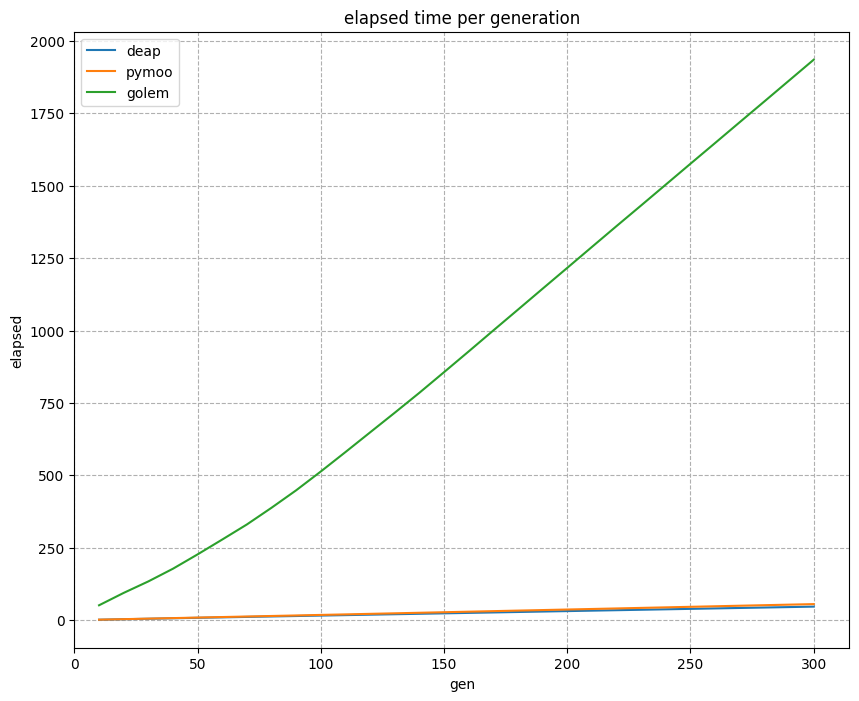

In [19]:
generation_time_plot(
    (
        np.mean(np.array([d[1] for d in deap_data]), axis=0),
        np.mean(np.array([d[2] for d in deap_data]), axis=0),
    ),
    (
        np.mean(np.array([d[1] for d in pymoo_data]), axis=0),
        np.mean(np.array([d[2] for d in pymoo_data]), axis=0),
    ),
    (
        np.mean(np.array([d[1] for d in golem_data]), axis=0),
        np.mean(np.array([d[2] for d in golem_data]), axis=0),
    ),
    
)

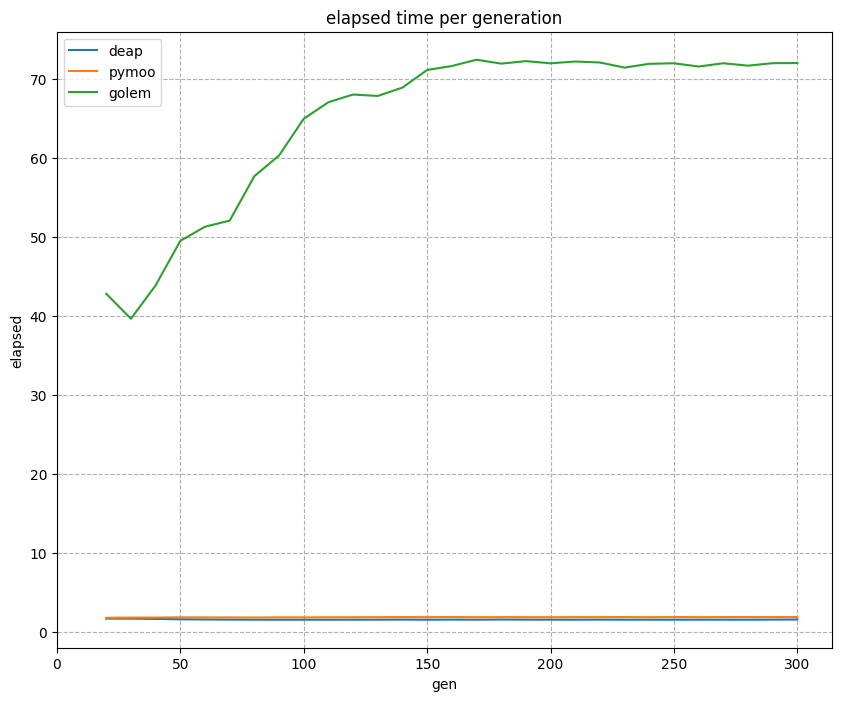

In [20]:
deap_elapsed = np.array([d[2] for d in deap_data])
pymoo_elapsed = np.array([d[2] for d in pymoo_data])
golem_elapsed = np.array([d[2] for d in golem_data])

generation_time_change_plot(
    (
        np.mean(np.array([d[1] for d in deap_data]), axis=0)[1:],
        np.mean(deap_elapsed[:,1:], axis=0) - np.mean(deap_elapsed[:,:-1], axis=0),
    ),
    (
        np.mean(np.array([d[1] for d in pymoo_data]), axis=0)[1:],
        np.mean(pymoo_elapsed[:,1:], axis=0) - np.mean(pymoo_elapsed[:,:-1], axis=0),
    ),
    (
        np.mean(np.array([d[1] for d in golem_data]), axis=0)[1:],
        np.mean(golem_elapsed[:,1:], axis=0) - np.mean(golem_elapsed[:,:-1], axis=0),
    ),
    
)

In [21]:
def dominates(pair1, pair2):
    return pair1[0] < pair2[0] and pair1[1] <= pair2[1] or pair1[0] <= pair2[0] and pair1[1] < pair2[1] 

# доминирует хотя бы раз
def dominates_set_1(pairs1, pairs2):
    result = []
    
    for pair1 in pairs1:
        flag = False
        for pair2 in pairs2:
            if dominates(pair1, pair2):
                flag = True
                break
        if flag:
            result.append(pair1)
    
    return np.array(result)

# доля решений среди pairs2, которые были доминированы pairs1
def dominance_ratio(pairs1, pairs2):
    n = len(pairs2)
    k = 0

    for pair2 in pairs2:        
        for pair1 in pairs1:
            if dominates(pair1, pair2):
                k += 1
                break
                
    return k / n

def domainance_per_gen(gen_count, framework1, framework2, tries_count=10):
    
    return [
    np.mean([
        dominance_ratio(framework1[i][gen_index], framework2[i][gen_index]) 
        for i 
        in range(tries_count)
    ]) 
    for gen_index 
    in range(gen_count)
]

In [22]:
tuples = [
    ('deap', 'pymoo'),
    ('deap', 'golem'),
    ('pymoo', 'deap'),
    ('pymoo', 'golem'),
    ('golem', 'deap'),
    ('golem', 'pymoo')
]

index = pd.MultiIndex.from_tuples(tuples, names=["framework", "dominance"])

deap_populations = [record[4] for record in deap_data]
pymoo_populations = [record[4] for record in pymoo_data]
golem_populations = [record[3] for record in golem_data]

gen_count = len(deap_data[0][1])
gen_count

dr_data = np.hstack(
    [
        np.array(domainance_per_gen(gen_count, deap_populations,  pymoo_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, deap_populations,  golem_populations)).reshape(-1, 1),
        np.array(domainance_per_gen(gen_count, pymoo_populations, deap_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, pymoo_populations, golem_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, golem_populations, deap_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, golem_populations, pymoo_populations)).reshape(-1, 1), 
    ]
)

df = pd.DataFrame(
    dr_data, 
    index=deap_data[0][1], 
    columns=index
)
df.index.name = 'gen'
df


# Как читать таблицу:
# первая колонка отвечает на вопрос: сколько в среднем решений на 10 генерации deap доминирует решений pymoo
# чем больше число - тем больше в среднем найдено лучших решений на данной генерации
#
# Важное замечание данные замечания несколько шумные, поэтому нужно будет произвести на 10 экспериментов, а хотя бы 50

framework      deap               pymoo               golem      
dominance     pymoo     golem      deap     golem      deap pymoo
gen                                                              
10         0.543333  1.000000  0.295317  1.000000  0.000000  0.00
20         0.338095  1.000000  0.563968  1.000000  0.000000  0.00
30         0.373810  1.000000  0.509903  1.000000  0.000000  0.00
40         0.367132  1.000000  0.582332  1.000000  0.000000  0.00
50         0.308242  1.000000  0.596373  1.000000  0.000000  0.00
60         0.271282  0.800000  0.648919  0.800000  0.200000  0.20
70         0.273965  0.600000  0.618005  0.588235  0.400000  0.42
80         0.219545  0.300000  0.673468  0.300000  0.700000  0.60
90         0.230007  0.300000  0.737096  0.300000  0.700000  0.60
100        0.172778  0.300000  0.810615  0.300000  0.700000  0.60
110        0.135316  0.292857  0.855631  0.300000  0.705000  0.60
120        0.118201  0.164706  0.865271  0.200000  0.802564  0.70
130        0.114815  0.100000  0.878750  0.100000  0.900000  0.80
140        0.117639  0.100000  0.881000  0.100000  0.900000  0.80
150        0.111601  0.100000  0.886909  0.100000  0.900000  0.80
160        0.106561  0.100000  0.888208  0.100000  0.900000  0.80
170        0.142001  0.100000  0.855025  0.100000  0.900000  0.80
180        0.141768  0.100000  0.816899  0.100000  0.900000  0.80
190        0.151437  0.100000  0.826416  0.100000  0.900000  0.80
200        0.209227  0.100000  0.767381  0.100000  0.900000  0.80
210        0.208976  0.100000  0.756505  0.100000  0.900000  0.80
220        0.245614  0.100000  0.721864  0.100000  0.900000  0.80
230        0.264362  0.100000  0.728745  0.100000  0.900000  0.80
240        0.255612  0.100000  0.727968  0.100000  0.900000  0.80
250        0.242011  0.100000  0.729958  0.100000  0.900000  0.80
260        0.243682  0.100000  0.709113  0.100000  0.900000  0.80
270        0.248079  0.100000  0.668751  0.100000  0.900000  0.80
280        0.268234  0.100000  0.693113  0.100000  0.900000  0.80
290        0.280640  0.100000  0.719496  0.100000  0.900000  0.80
300        0.265921  0.100000  0.681049  0.100000  0.900000  0.80

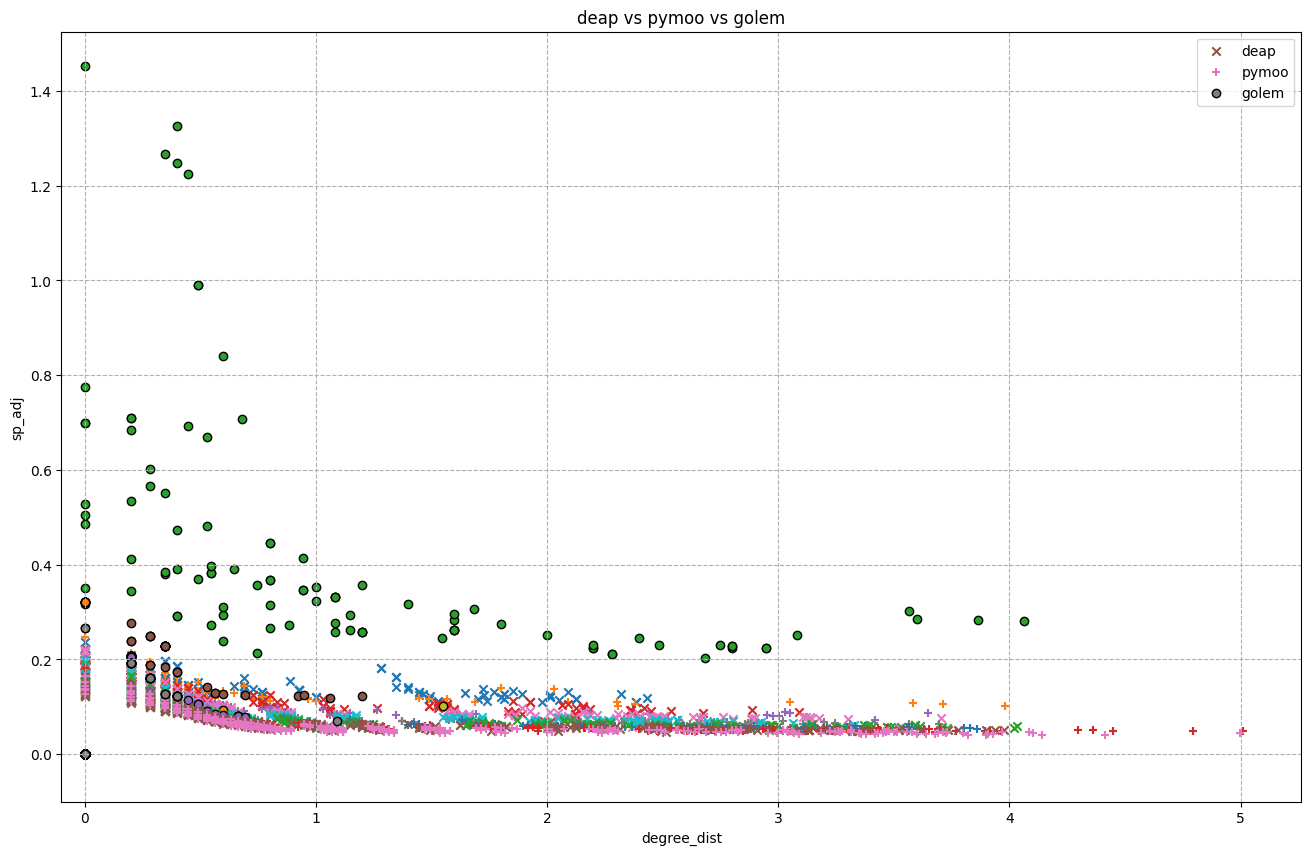

In [23]:
import matplotlib.pyplot as plt


_, ax = plt.subplots(figsize=(16, 10))

ax.grid(True, linestyle="--")

#deap_colormap = color_gradient('#d7d7d7', '#000000', gen_count)
#pymoo_colormap = color_gradient('#90ee90', '#0000ff', gen_count)
#golem_colormap = color_gradient('#ffff00', '#ff0000', gen_count)

for gen_index in range(4, gen_count, 5):

    deap_metrics = np.hstack(
        [ 
            np.array(deap_data[try_index][4][gen_index]).T
            for try_index 
            in range(N_TRIES)
        ]
    )
    deap_plot = ax.scatter(deap_metrics[0], deap_metrics[1], marker='x', edgecolors='black', label='deap')
    
    pymoo_metrics = np.hstack(
        [ 
            np.array(pymoo_data[try_index][4][gen_index]).T
            for try_index 
            in range(N_TRIES)
        ]
    )
    pymoo_plot = ax.scatter(pymoo_metrics[0], pymoo_metrics[1], marker='+', edgecolors='black', label='pymoo')

    golem_metrics = np.hstack(
        [ 
            np.array(golem_data[try_index][3][gen_index]).T
            for try_index 
            in range(N_TRIES)
        ]
    )
    golem_plot = ax.scatter(golem_metrics[0], golem_metrics[1], marker='o', edgecolors='black', label='golem')



ax.set_xlabel("degree_dist")
ax.set_ylabel("sp_adj")

ax.set_xlim(-0.1)
ax.set_ylim(-0.1)

ax.legend(handles=[deap_plot, pymoo_plot, golem_plot])
plt.title("deap vs pymoo vs golem")

plt.show()

# На графике изображены 50, 100, 150, 200, 250, 300 популяции

# Эксперимент 2: golem + free schema

In [149]:
from datetime import timedelta
from functools import partial
from typing import Type, Optional, Sequence, List

from examples.synthetic_graph_evolution.experiment_setup import run_experiments
from golem.core.adapter.nx_adapter import BaseNetworkxAdapter
from golem.core.dag.graph import Graph
from golem.core.dag.verification_rules import DEFAULT_DAG_RULES
from golem.core.optimisers.adaptive.operator_agent import MutationAgentTypeEnum
from golem.core.optimisers.genetic.gp_optimizer import EvoGraphOptimizer
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.base_mutations import MutationTypesEnum
from golem.core.optimisers.genetic.operators.crossover import CrossoverTypesEnum
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from golem.core.optimisers.objective import Objective
from golem.core.optimisers.optimization_parameters import GraphRequirements
from golem.core.optimisers.optimizer import GraphGenerationParams, GraphOptimizer, AlgorithmParameters
from golem.metrics.graph_metrics import spectral_dist, size_diff, degree_distance
from golem.core.dag.convert import graph_structure_as_nx_graph
from golem.core.optimisers.genetic.operators.selection import SelectionTypesEnum
from golem.core.dag.verification_rules import has_no_isolated_nodes

#global_evaluation_count = 0

class PatchedEvoGraphOptimizer(EvoGraphOptimizer):
    def __init__(
        self,
        objective,
        initial_graphs,
        requirements,
        graph_generation_params,
        graph_optimizer_params,
        generation_log
    ):
        super().__init__(objective, initial_graphs, requirements, graph_generation_params, graph_optimizer_params)

        self._generation_log = generation_log

        self.generation_count = []
        self.elapsed_count = []
        self.evaluation_count = []
        self.pareto_front_values = []
        
        self._iteration_callback = self.generation_callback

        #self.set_evaluation_callback(self.evaluation_callback)

    @staticmethod
    def generation_callback(next_generation, optimizer):

        if optimizer.generations.generation_num % optimizer._generation_log == 0:
            global global_evaluation_count
            
            gen = optimizer.generations.generation_num
            elapsed = optimizer.timer.spent_time

            optimizer.generation_count.append(gen)
            optimizer.elapsed_count.append(elapsed.seconds + elapsed.microseconds / 1e6)
            #optimizer.evaluation_count.append(global_evaluation_count)
            optimizer.pareto_front_values.append([ind.fitness.getValues() for ind in optimizer.best_individuals])

            print("gen:", gen, "elapsed:", elapsed.seconds + elapsed.microseconds / 1e6)
            
    #@staticmethod
    #def evaluation_callback(x):
    #    global global_evaluation_count
    #    global_evaluation_count += 1
        


def golem_run(
    generations_limit,
    generation_log,
    search_space_size,
    initial_population,
    metrics,
    pop_size=100,
    ):

    objective = Objective(
        quality_metrics={'sp_adj': metrics[0]},
        complexity_metrics={'degree_dist': metrics[1]},
        is_multi_objective=True,
    )

    requirements = GraphRequirements(
        max_arity=search_space_size,
        min_arity=1,
        max_depth=search_space_size,
        early_stopping_iterations=None,
        early_stopping_timeout=10000000,
        keep_n_best=4,
        timeout=None,
        num_of_generations=generations_limit,
        n_jobs=-1,
        #parallelization_mode=None,
        show_progress=False,
        history_dir=None,
        keep_history=False,
    )

    default_gp_params = GPAlgorithmParameters(
        adaptive_mutation_type=MutationAgentTypeEnum.random,
        multi_objective=True,
        max_pop_size=pop_size,
        # steady_state
        genetic_scheme_type=GeneticSchemeTypesEnum.parameter_free,
        selection_types=[
            SelectionTypesEnum.spea2,
        ],
        mutation_types=[
            MutationTypesEnum.single_add,
            MutationTypesEnum.single_edge,
            MutationTypesEnum.single_drop,
        ],
        crossover_types=[
            CrossoverTypesEnum.one_point
        ],
        crossover_prob=0.9,
    )

    graph_gen_params = GraphGenerationParams(
        adapter=BaseNetworkxAdapter(),
        rules_for_constraint=[has_no_isolated_nodes],
        available_node_types=('x', ),
    )

    optimizer = PatchedEvoGraphOptimizer(objective, initial_population, requirements, graph_gen_params, default_gp_params, generation_log)

    found_graphs = optimizer.optimise(objective)

    return (
        [get_adj_vector(graph_structure_as_nx_graph(ind.graph)[0], search_space_size) for ind in optimizer.best_individuals],
        optimizer.generation_count,
        optimizer.elapsed_count,
        optimizer.pareto_front_values
    )


In [150]:
import logging 

logger = logging.getLogger()
logger.disabled = True

for _ in range(N_TRIES):

    init_pop = [get_adj_vector(ind, 60) for ind in problem1[4]]

    golem_result = golem_run(
        generations_limit=300,
        generation_log=10,
        search_space_size=60,
        initial_population=problem1[4],
        metrics=problem1[2],
        pop_size=100,
    )
    
    save_as_pickle(golem_result, 'free/golem')
    
    print('-----')  

logger.disabled = False

gen: 10 elapsed: 22.514087
gen: 20 elapsed: 29.361151
gen: 30 elapsed: 33.660465
gen: 40 elapsed: 50.788223
gen: 50 elapsed: 63.610629
gen: 60 elapsed: 111.274303
gen: 70 elapsed: 160.764531
gen: 80 elapsed: 197.874539
gen: 90 elapsed: 228.121249
gen: 100 elapsed: 260.88136
gen: 110 elapsed: 293.151759
gen: 120 elapsed: 325.214985
gen: 130 elapsed: 357.550937
gen: 140 elapsed: 389.777416
gen: 150 elapsed: 422.509156
gen: 160 elapsed: 454.548919
gen: 170 elapsed: 487.107015
gen: 180 elapsed: 519.239702
gen: 190 elapsed: 551.375272
gen: 200 elapsed: 583.453944
gen: 210 elapsed: 615.723278
gen: 220 elapsed: 647.960951
gen: 230 elapsed: 680.156659
gen: 240 elapsed: 712.543282
gen: 250 elapsed: 744.649432
gen: 260 elapsed: 776.705462
gen: 270 elapsed: 808.952917
gen: 280 elapsed: 841.259403
gen: 290 elapsed: 873.411712
gen: 300 elapsed: 905.632007
-----
gen: 10 elapsed: 7.743917
gen: 20 elapsed: 19.331817
gen: 30 elapsed: 39.944798
gen: 40 elapsed: 42.999849
gen: 50 elapsed: 45.45847
gen: 6

In [151]:
golem_free_data = read_pickle_folder('free/golem')

In [152]:
def generation_time_plot(golem_data, golem_free_data):
    import matplotlib.pyplot as plt
    plt.rcParams.update({'figure.dpi': '100'})
    
    _, ax = plt.subplots(figsize=(10, 8))
    
    ax.grid(True, linestyle="--")
    
    ax.plot(golem_data[0], golem_data[1])
    ax.plot(golem_free_data[0], golem_free_data[1])

    ax.set_xlim(0)

    ax.set_title("elapsed time per generation")

    ax.set_xlabel("gen")
    ax.set_ylabel("elapsed")

    ax.legend(['golem', 'golem parameter_free'])
    
    plt.show()


def generation_time_change_plot(golem_data, golem_free_data):
    import matplotlib.pyplot as plt
    plt.rcParams.update({'figure.dpi': '100'})
    
    _, ax = plt.subplots(figsize=(10, 8))
    
    ax.grid(True, linestyle="--")

    ax.plot(golem_data[0], golem_data[1])
    ax.plot(golem_free_data[0], golem_free_data[1])

    ax.set_xlim(0)

    ax.set_title("elapsed time per generation")

    ax.set_xlabel("gen")
    ax.set_ylabel("elapsed")

    ax.legend(['golem', 'golem parameter_free'])
    
    plt.show()

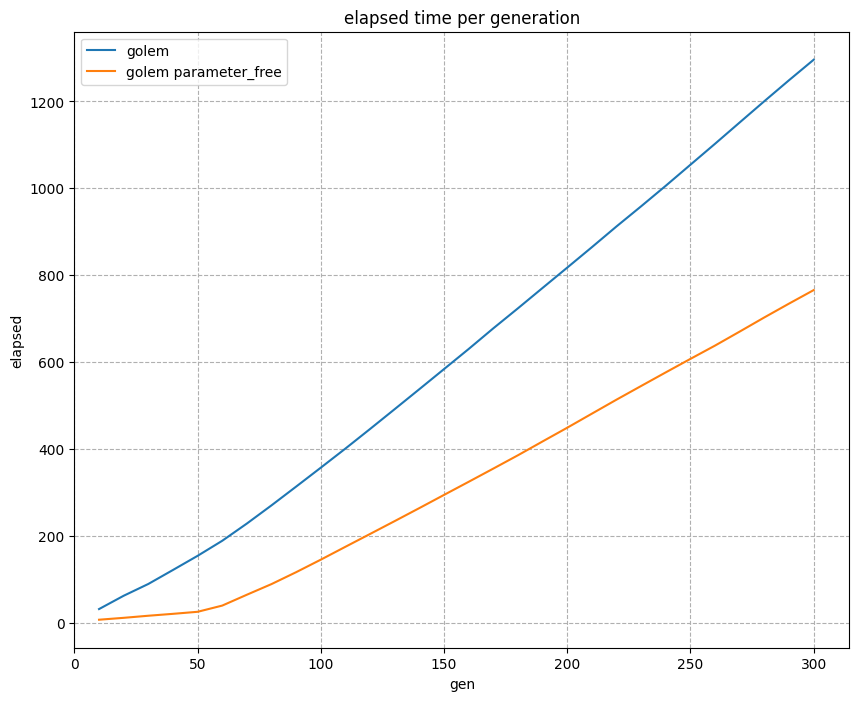

In [153]:
generation_time_plot(
    (
        np.mean(np.array([d[1] for d in golem_data]), axis=0),
        np.mean(np.array([d[2] for d in golem_data]), axis=0),
    ),
    (
        np.mean(np.array([d[1] for d in golem_free_data]), axis=0),
        np.mean(np.array([d[2] for d in golem_free_data]), axis=0),
    )
)

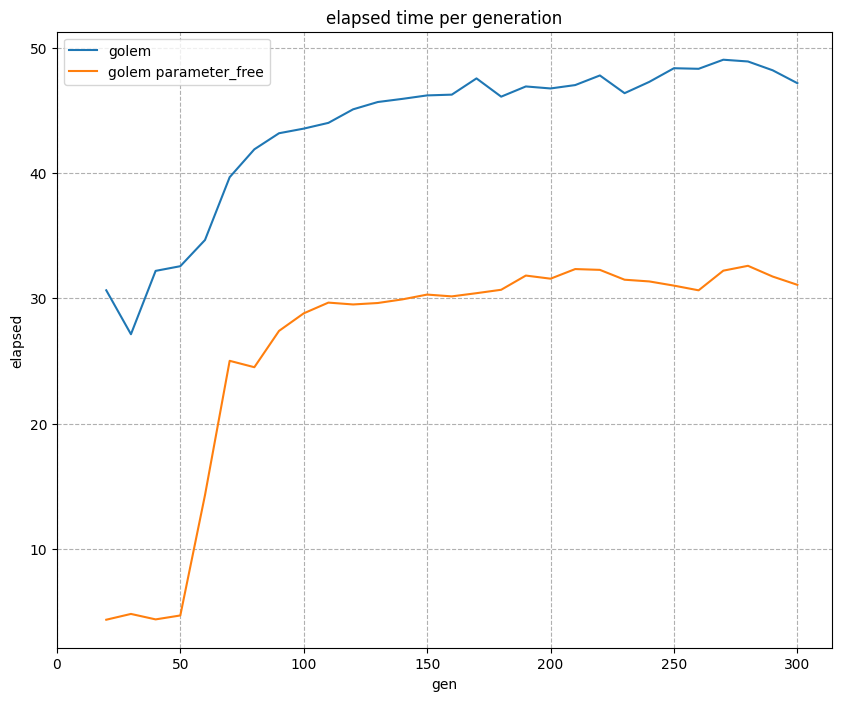

In [154]:
golem_elapsed = np.array([d[2] for d in golem_data])
golem_free_elapsed = np.array([d[2] for d in golem_free_data])

generation_time_change_plot(
    (
        np.mean(np.array([d[1] for d in golem_data]), axis=0)[1:],
        np.mean(golem_elapsed[:,1:], axis=0) - np.mean(golem_elapsed[:,:-1], axis=0),
    ),
    (
        np.mean(np.array([d[1] for d in golem_free_data]), axis=0)[1:],
        np.mean(golem_free_elapsed[:,1:], axis=0) - np.mean(golem_free_elapsed[:,:-1], axis=0),
    ),
)

framework,golem,golem_parameter-free
dominance,golem_parameter-free,golem
gen,,
10,0.750000,0.091667
20,0.950000,0.000000
30,1.000000,0.000000
40,1.000000,0.000000
50,1.000000,0.000000
60,0.860000,0.022222
70,0.500000,0.200000
80,0.350000,0.205000


In [158]:
tuples = [
    ('deap', 'pymoo'),
    ('deap', 'golem'),
    ('deap', 'golem_free'),
    ('pymoo', 'deap'),
    ('pymoo', 'golem'),
    ('pymoo', 'golem_free'),
    ('golem', 'deap'),
    ('golem', 'pymoo'),
    ('golem', 'golem_free'),
    ('golem_free', 'deap'),
    ('golem_free', 'pymoo'),
    ('golem_free', 'golem'),
]

index = pd.MultiIndex.from_tuples(tuples, names=["framework", "dominance"])

deap_populations = [record[4] for record in deap_data]
pymoo_populations = [record[4] for record in pymoo_data]
golem_populations = [record[3] for record in golem_data]
golem_free_populations = [record[3] for record in golem_free_data]

gen_count = len(deap_data[0][1])
gen_count

dr_data = np.hstack(
    [
        np.array(domainance_per_gen(gen_count, deap_populations,  pymoo_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, deap_populations,  golem_populations)).reshape(-1, 1),
        np.array(domainance_per_gen(gen_count, deap_populations,  golem_free_populations)).reshape(-1, 1),
        np.array(domainance_per_gen(gen_count, pymoo_populations, deap_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, pymoo_populations, golem_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, pymoo_populations, golem_free_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, golem_populations, deap_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, golem_populations, pymoo_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, golem_populations, golem_free_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, golem_free_populations, deap_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, golem_free_populations, pymoo_populations)).reshape(-1, 1), 
        np.array(domainance_per_gen(gen_count, golem_free_populations, golem_populations)).reshape(-1, 1), 
    ]
)

df = pd.DataFrame(
    dr_data, 
    index=deap_data[0][1], 
    columns=index
)
df.index.name = 'gen'
df


# Как читать таблицу:
# первая колонка отвечает на вопрос: сколько в среднем решений на 10 генерации deap доминирует решений pymoo
# чем больше число - тем больше в среднем найдено лучших решений на данной генерации
#
# Важное замечание данные замечания несколько шумные, поэтому нужно будет произвести на 10 экспериментов, а хотя бы 50

framework      deap                          pymoo                      golem  \
dominance     pymoo     golem golem_free      deap golem golem_free      deap   
gen                                                                             
10         0.570714  1.000000        1.0  0.216667   1.0      1.000  0.000000   
20         0.646429  1.000000        1.0  0.331136   1.0      1.000  0.000000   
30         0.522214  1.000000        1.0  0.437059   1.0      1.000  0.000000   
40         0.514155  0.800000        1.0  0.390661   0.8      1.000  0.200000   
50         0.531388  0.500000        1.0  0.348606   0.5      1.000  0.500000   
60         0.416025  0.393750        0.9  0.527856   0.4      0.900  0.628571   
70         0.361901  0.300000        0.5  0.577515   0.3      0.500  0.700000   
80         0.330186  0.300000        0.4  0.655551   0.3      0.400  0.700000   
90         0.385112  0.300000        0.4  0.581492   0.3      0.400  0.700000   
100        0.309827  0.294444        0.4  0.569640   0.3      0.400  0.700000   
110        0.321037  0.290000        0.4  0.620768   0.3      0.400  0.700000   
120        0.307635  0.300000        0.3  0.618464   0.3      0.300  0.700000   
130        0.333877  0.300000        0.3  0.600407   0.3      0.300  0.700000   
140        0.328184  0.300000        0.3  0.618417   0.3      0.300  0.700000   
150        0.372270  0.300000        0.3  0.560082   0.3      0.300  0.700000   
160        0.442784  0.300000        0.3  0.542007   0.3      0.300  0.700000   
170        0.409439  0.300000        0.2  0.529005   0.3      0.200  0.700000   
180        0.435050  0.300000        0.2  0.527663   0.3      0.200  0.700000   
190        0.384400  0.300000        0.2  0.622191   0.3      0.200  0.700000   
200        0.395467  0.300000        0.2  0.593343   0.3      0.200  0.700000   
210        0.405631  0.300000        0.2  0.555879   0.3      0.200  0.700000   
220        0.367615  0.300000        0.2  0.560321   0.3      0.185  0.700000   
230        0.403234  0.300000        0.2  0.541751   0.3      0.185  0.700000   
240        0.408607  0.300000        0.2  0.517880   0.3      0.160  0.700000   
250        0.424369  0.300000        0.2  0.482681   0.3      0.150  0.700000   
260        0.457321  0.300000        0.2  0.450309   0.3      0.140  0.700000   
270        0.460009  0.300000        0.2  0.435014   0.3      0.140  0.700000   
280        0.450589  0.300000        0.2  0.433061   0.3      0.140  0.700000   
290        0.473736  0.300000        0.2  0.421041   0.3      0.190  0.700000   
300        0.481733  0.300000        0.2  0.408899   0.3      0.190  0.700000   

framework                  golem_free                      
dominance pymoo golem_free       deap     pymoo     golem  
gen                                                        
10          0.0   0.750000        0.0  0.000000  0.091667  
20          0.0   0.950000        0.0  0.000000  0.000000  
30          0.0   1.000000        0.0  0.000000  0.000000  
40          0.2   1.000000        0.0  0.000000  0.000000  
50          0.5   1.000000        0.0  0.000000  0.000000  
60          0.6   0.860000        0.1  0.100000  0.022222  
70          0.7   0.500000        0.5  0.500000  0.200000  
80          0.7   0.350000        0.6  0.600000  0.205000  
90          0.7   0.310000        0.6  0.600000  0.205000  
100         0.7   0.357143        0.6  0.600000  0.246154  
110         0.7   0.355000        0.6  0.600000  0.280000  
120         0.7   0.220000        0.7  0.700000  0.280000  
130         0.7   0.220000        0.7  0.700000  0.280000  
140         0.7   0.215000        0.7  0.700000  0.280000  
150         0.7   0.205000        0.7  0.700000  0.280000  
160         0.7   0.205000        0.7  0.700000  0.295000  
170         0.7   0.200000        0.8  0.800000  0.300000  
180         0.7   0.200000        0.8  0.800000  0.300000  
190         0.7   0.200000        0.8  0.800000  0.300000  
200   

# Эксперимент 3: однокритериальная оптимизация

In [163]:
import array
from deap import base, creator

creator.create("FitnessMin", base.Fitness, weights=(-1.0, ))
creator.create("Individual", array.array, typecode='h', fitness=creator.FitnessMin)

In [164]:
import time
from deap import tools


def pareto_front(initial_population):
    hof = tools.ParetoFront()
    
    pop = [creator.Individual(vector) for vector in initial_population]

    hof.update(pop)

    return [np.array(ind, np.int8) for ind in hof.items]
    

def deap_run(
    generations_limit,
    generation_log,
    search_space_size,
    initial_population,
    metric,
    pop_size=100,
    cx_prob=0.9,
    ):


    toolbox = base.Toolbox()

    toolbox.register(
        "evaluate",
        lambda individual: [metric(get_adj_matrix_from_vector(individual))]
    )

    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=1/(search_space_size**2))
    toolbox.register("select", tools.selNSGA2)

    # register pareto front
    hof = tools.ParetoFront()

    logbook = tools.Logbook()
    
    pop = [creator.Individual(vector) for vector in initial_population]

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))

    hof.update(pop)

    current_generation = 0
    current_evaluation_count = 0
    _start_time = time.time()

    while current_generation < generations_limit:
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() <= cx_prob:
                toolbox.mate(ind1, ind2)

            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population
        pop = toolbox.select(pop + offspring, pop_size)

        current_generation += 1
        current_evaluation_count += len(invalid_ind)

        if current_generation % generation_log == 0:
            
            elapsed = time.time() - _start_time
            hof.update(pop)
            logbook.record(
                generation_count=current_generation, 
                elapsed_count=elapsed,
                evaluation_count=current_evaluation_count,
                pareto_front_values=[ind.fitness.values for ind in hof.items.copy()],
            )

            print("gen:", current_generation, "eval:", current_evaluation_count, "elapsed:", elapsed)

    solution = [np.array(ind, np.int8) for ind in hof.items]
    
    return (
        solution, 
        logbook.select('generation_count'), 
        logbook.select('elapsed_count'),
        logbook.select('evaluation_count'), 
        logbook.select('pareto_front_values')
    )

In [170]:
import time
import datetime

from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.callback import Callback
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import SinglePointCrossover

from pymoo.core.mutation import Mutation

class PatchedBitflipMutation(Mutation):

    def _do(self, problem, X, **kwargs):
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        Xp = np.copy(X).astype(np.bool_)
        flip = np.random.random(X.shape) < prob_var
        Xp[flip] = ~X[flip]
        return Xp.astype(np.int8)

class MetricsCallback(Callback):
    def __init__(self, generation_log) -> None:
        super().__init__()

        self._generation_log = generation_log

        self.generation_count = []
        self.elapsed_count = []
        self.evaluation_count = []
        self.pareto_front_values = []


    def notify(self, algorithm):
        
        
        if algorithm.n_gen % self._generation_log == 0:
            
            elapsed = time.time() - algorithm.start_time

            self.generation_count.append(algorithm.n_gen)
            self.elapsed_count.append(elapsed)
            self.evaluation_count.append(algorithm.evaluator.n_eval)
            self.pareto_front_values.append(algorithm.opt.collect(lambda ind: ind.F))

            print("gen:", algorithm.n_gen, "eval:", algorithm.evaluator.n_eval, "elapsed:", elapsed)


def pymoo_run(
    generations_limit,
    generation_log,
    search_space_size,
    initial_population,
    metric,
    pop_size=100,
    cx_prob=0.9,
    ):

    class PymooProblem(ElementwiseProblem):
        def __init__(self, metric, **kwargs):
            super().__init__(**kwargs)
            self.metric = metric

        def _evaluate(self, x, out, *args, **kwargs):
            adj_vector = get_adj_matrix_from_vector(x)
            out["F"] = [metric(adj_vector)]

    pymoo_nsga2 = NSGA2(
        pop_size=pop_size,
        sampling=np.array(initial_population),
        crossover=SinglePointCrossover(prob=cx_prob),
        mutation=PatchedBitflipMutation(),
    )

    pymoo_problem = PymooProblem(
        metric=metric,
        n_var=search_space_size**2,
        n_obj=1,
        xl=np.zeros(search_space_size**2, np.int8),
        xu=np.ones(search_space_size**2, np.int8),
        vtype=int,
    )

    pymoo_nsga2_res = minimize(
        problem=pymoo_problem,
        algorithm=pymoo_nsga2,
        termination=get_termination("n_gen", generations_limit),
        callback=MetricsCallback(generation_log),
        verbose=False,
    )

    callback = pymoo_nsga2_res.algorithm.callback

    return (
        pymoo_nsga2_res.algorithm.opt.collect(lambda ind: ind.X),
        callback.generation_count,
        callback.elapsed_count,
        callback.evaluation_count,
        callback.pareto_front_values,
    )

In [183]:
from datetime import timedelta
from functools import partial
from typing import Type, Optional, Sequence, List

from examples.synthetic_graph_evolution.experiment_setup import run_experiments
from golem.core.adapter.nx_adapter import BaseNetworkxAdapter
from golem.core.dag.graph import Graph
from golem.core.dag.verification_rules import DEFAULT_DAG_RULES
from golem.core.optimisers.adaptive.operator_agent import MutationAgentTypeEnum
from golem.core.optimisers.genetic.gp_optimizer import EvoGraphOptimizer
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.base_mutations import MutationTypesEnum
from golem.core.optimisers.genetic.operators.crossover import CrossoverTypesEnum
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from golem.core.optimisers.objective import Objective
from golem.core.optimisers.optimization_parameters import GraphRequirements
from golem.core.optimisers.optimizer import GraphGenerationParams, GraphOptimizer, AlgorithmParameters
from golem.metrics.graph_metrics import spectral_dist, size_diff, degree_distance
from golem.core.dag.convert import graph_structure_as_nx_graph
from golem.core.optimisers.genetic.operators.selection import SelectionTypesEnum
from golem.core.dag.verification_rules import has_no_isolated_nodes

#global_evaluation_count = 0

class PatchedEvoGraphOptimizer(EvoGraphOptimizer):
    def __init__(
        self,
        objective,
        initial_graphs,
        requirements,
        graph_generation_params,
        graph_optimizer_params,
        generation_log
    ):
        super().__init__(objective, initial_graphs, requirements, graph_generation_params, graph_optimizer_params)

        self._generation_log = generation_log

        self.generation_count = []
        self.elapsed_count = []
        self.evaluation_count = []
        self.pareto_front_values = []
        
        self._iteration_callback = self.generation_callback

        #self.set_evaluation_callback(self.evaluation_callback)

    @staticmethod
    def generation_callback(next_generation, optimizer):

        if optimizer.generations.generation_num % optimizer._generation_log == 0:
            global global_evaluation_count
            
            gen = optimizer.generations.generation_num
            elapsed = optimizer.timer.spent_time

            optimizer.generation_count.append(gen)
            optimizer.elapsed_count.append(elapsed.seconds + elapsed.microseconds / 1e6)
            #optimizer.evaluation_count.append(global_evaluation_count)
            optimizer.pareto_front_values.append([ind.fitness.getValues() for ind in optimizer.best_individuals])

            print("gen:", gen, "elapsed:", elapsed.seconds + elapsed.microseconds / 1e6)
            
    #@staticmethod
    #def evaluation_callback(x):
    #    global global_evaluation_count
    #    global_evaluation_count += 1
        


def golem_run(
    generations_limit,
    generation_log,
    search_space_size,
    initial_population,
    metrics,
    pop_size=100,
    ):

    objective = Objective(
        quality_metrics={'sp_adj': metrics[0]},
        is_multi_objective=True,
    )

    requirements = GraphRequirements(
        max_arity=search_space_size,
        min_arity=1,
        max_depth=search_space_size,
        early_stopping_iterations=None,
        early_stopping_timeout=10000000,
        keep_n_best=4,
        timeout=None,
        num_of_generations=generations_limit,
        n_jobs=-1,
        #parallelization_mode=None,
        show_progress=False,
        history_dir=None,
        keep_history=False,
    )

    default_gp_params = GPAlgorithmParameters(
        adaptive_mutation_type=MutationAgentTypeEnum.random,
        multi_objective=True,
        max_pop_size=pop_size,
        # steady_state
        genetic_scheme_type=GeneticSchemeTypesEnum.steady_state,
        selection_types=[
            SelectionTypesEnum.spea2,
        ],
        mutation_types=[
            MutationTypesEnum.single_add,
            MutationTypesEnum.single_edge,
            MutationTypesEnum.single_drop,
        ],
        crossover_types=[
            CrossoverTypesEnum.one_point
        ],
        crossover_prob=0.9,
    )

    graph_gen_params = GraphGenerationParams(
        adapter=BaseNetworkxAdapter(),
        rules_for_constraint=[has_no_isolated_nodes],
        available_node_types=('x', ),
    )
    

    optimizer = PatchedEvoGraphOptimizer(objective, initial_population, requirements, graph_gen_params, default_gp_params, generation_log)

    found_graphs = optimizer.optimise(objective)

    return (
        [get_adj_vector(graph_structure_as_nx_graph(ind.graph)[0], search_space_size) for ind in optimizer.best_individuals],
        optimizer.generation_count,
        optimizer.elapsed_count,
        optimizer.pareto_front_values
    )


In [184]:
class PatchedEvoGraphOptimizer(EvoGraphOptimizer):
    def __init__(
        self,
        objective,
        initial_graphs,
        requirements,
        graph_generation_params,
        graph_optimizer_params,
        generation_log
    ):
        super().__init__(objective, initial_graphs, requirements, graph_generation_params, graph_optimizer_params)

        self._generation_log = generation_log

        self.generation_count = []
        self.elapsed_count = []
        self.evaluation_count = []
        self.pareto_front_values = []
        
        self._iteration_callback = self.generation_callback

        #self.set_evaluation_callback(self.evaluation_callback)

    @staticmethod
    def generation_callback(next_generation, optimizer):

        if optimizer.generations.generation_num % optimizer._generation_log == 0:
            global global_evaluation_count
            
            gen = optimizer.generations.generation_num
            elapsed = optimizer.timer.spent_time

            optimizer.generation_count.append(gen)
            optimizer.elapsed_count.append(elapsed.seconds + elapsed.microseconds / 1e6)
            #optimizer.evaluation_count.append(global_evaluation_count)
            optimizer.pareto_front_values.append([ind.fitness.getValues() for ind in optimizer.best_individuals])

            print("gen:", gen, "elapsed:", elapsed.seconds + elapsed.microseconds / 1e6)
            
    #@staticmethod
    #def evaluation_callback(x):
    #    global global_evaluation_count
    #    global_evaluation_count += 1
        


def golem_free_run(
    generations_limit,
    generation_log,
    search_space_size,
    initial_population,
    metrics,
    pop_size=100,
    ):

    objective = Objective(
        quality_metrics={'sp_adj': metrics[0]},
        is_multi_objective=True,
    )

    requirements = GraphRequirements(
        max_arity=search_space_size,
        min_arity=1,
        max_depth=search_space_size,
        early_stopping_iterations=None,
        early_stopping_timeout=10000000,
        keep_n_best=4,
        timeout=None,
        num_of_generations=generations_limit,
        n_jobs=-1,
        #parallelization_mode=None,
        show_progress=False,
        history_dir=None,
        keep_history=False,
    )

    default_gp_params = GPAlgorithmParameters(
        adaptive_mutation_type=MutationAgentTypeEnum.random,
        multi_objective=True,
        max_pop_size=pop_size,
        # steady_state
        genetic_scheme_type=GeneticSchemeTypesEnum.parameter_free,
        selection_types=[
            SelectionTypesEnum.spea2,
        ],
        mutation_types=[
            MutationTypesEnum.single_add,
            MutationTypesEnum.single_edge,
            MutationTypesEnum.single_drop,
        ],
        crossover_types=[
            CrossoverTypesEnum.one_point
        ],
        crossover_prob=0.9,
    )

    graph_gen_params = GraphGenerationParams(
        adapter=BaseNetworkxAdapter(),
        rules_for_constraint=[has_no_isolated_nodes],
        available_node_types=('x', ),
    )

    optimizer = PatchedEvoGraphOptimizer(objective, initial_population, requirements, graph_gen_params, default_gp_params, generation_log)

    found_graphs = optimizer.optimise(objective)

    return (
        [get_adj_vector(graph_structure_as_nx_graph(ind.graph)[0], search_space_size) for ind in optimizer.best_individuals],
        optimizer.generation_count,
        optimizer.elapsed_count,
        optimizer.pareto_front_values
    )


In [219]:
for _ in range(N_TRIES):
    
    init_pop = [get_adj_vector(ind, 150) for ind in problem3[4]]
    
    deap_result = deap_run(
        generations_limit=100,
        generation_log=5,
        search_space_size=150,
        initial_population=init_pop,
        metric=problem3[3][0],
        pop_size=100,
    )
    
    save_as_pickle(deap_result, 'one_criteria/deap')
    
    print('-----')    

gen: 5 eval: 500 elapsed: 1.8909595012664795
gen: 10 eval: 1000 elapsed: 3.8207643032073975
gen: 15 eval: 1500 elapsed: 5.71460747718811
gen: 20 eval: 2000 elapsed: 7.6260881423950195
gen: 25 eval: 2500 elapsed: 9.523211002349854
gen: 30 eval: 3000 elapsed: 11.435587882995605
gen: 35 eval: 3500 elapsed: 13.356791019439697
gen: 40 eval: 4000 elapsed: 15.338303327560425
gen: 45 eval: 4500 elapsed: 17.271145582199097
gen: 50 eval: 5000 elapsed: 19.1708345413208
gen: 55 eval: 5500 elapsed: 21.062625408172607
gen: 60 eval: 6000 elapsed: 22.950220584869385
gen: 65 eval: 6500 elapsed: 24.837037086486816
gen: 70 eval: 7000 elapsed: 26.74536371231079
gen: 75 eval: 7500 elapsed: 28.65119981765747
gen: 80 eval: 8000 elapsed: 30.527111530303955
gen: 85 eval: 8500 elapsed: 32.418627977371216
gen: 90 eval: 9000 elapsed: 34.31208419799805
gen: 95 eval: 9500 elapsed: 36.198328495025635
gen: 100 eval: 10000 elapsed: 38.1066460609436
-----
gen: 5 eval: 500 elapsed: 1.895414113998413
gen: 10 eval: 1000 e

In [220]:
for _ in range(N_TRIES):
    
    init_pop = [get_adj_vector(ind, 150) for ind in problem3[4]]
    
    pymoo_result = pymoo_run(
        generations_limit=100,
        generation_log=5,
        search_space_size=150,
        initial_population=init_pop,
        metric=problem1[3][0],
        pop_size=100,
    )
    
    save_as_pickle(pymoo_result, 'one_criteria/pymoo')
    
    print('-----')    

gen: 5 eval: 500 elapsed: 2.213048219680786
gen: 10 eval: 1000 elapsed: 4.46694803237915
gen: 15 eval: 1500 elapsed: 6.63374137878418
gen: 20 eval: 2000 elapsed: 8.87570071220398
gen: 25 eval: 2500 elapsed: 11.063884735107422
gen: 30 eval: 3000 elapsed: 13.251458406448364
gen: 35 eval: 3500 elapsed: 15.455875158309937
gen: 40 eval: 4000 elapsed: 17.66347599029541
gen: 45 eval: 4500 elapsed: 19.813321352005005
gen: 50 eval: 5000 elapsed: 21.981231927871704
gen: 55 eval: 5500 elapsed: 24.131142377853394
gen: 60 eval: 6000 elapsed: 26.337438344955444
gen: 65 eval: 6500 elapsed: 28.47465443611145
gen: 70 eval: 7000 elapsed: 30.637576818466187
gen: 75 eval: 7500 elapsed: 32.792319536209106
gen: 80 eval: 8000 elapsed: 35.02686810493469
gen: 85 eval: 8500 elapsed: 37.13524341583252
gen: 90 eval: 9000 elapsed: 39.29372429847717
gen: 95 eval: 9500 elapsed: 41.391828775405884
gen: 100 eval: 10000 elapsed: 43.54805302619934
-----
gen: 5 eval: 500 elapsed: 2.144619941711426
gen: 10 eval: 1000 elap

In [221]:
import logging 

logger = logging.getLogger()
logger.disabled = True


for _ in range(N_TRIES):

    init_pop = [get_adj_vector(ind, 150) for ind in problem3[4]]

    golem_result = golem_run(
        generations_limit=100,
        generation_log=5,
        search_space_size=150,
        initial_population=problem1[4],
        metrics=problem3[2],
        pop_size=100,
    )
    
    save_as_pickle(golem_result, 'one_criteria/golem')
    
    print('-----')  
    
logger.disabled = False

gen: 5 elapsed: 18.841376
gen: 10 elapsed: 36.235187
gen: 15 elapsed: 51.031467
gen: 20 elapsed: 61.265476
gen: 25 elapsed: 72.336873
gen: 30 elapsed: 84.70531
gen: 35 elapsed: 97.655112
gen: 40 elapsed: 111.859959
gen: 45 elapsed: 128.393607
gen: 50 elapsed: 146.048461
gen: 55 elapsed: 167.017094
gen: 60 elapsed: 190.622188
gen: 65 elapsed: 215.301013
gen: 70 elapsed: 244.316156
gen: 75 elapsed: 274.128958
gen: 80 elapsed: 308.253906
gen: 85 elapsed: 347.831863
gen: 90 elapsed: 394.491447
gen: 95 elapsed: 447.272455
gen: 100 elapsed: 509.370068
-----
gen: 5 elapsed: 12.577371
gen: 10 elapsed: 23.776137
gen: 15 elapsed: 35.200243
gen: 20 elapsed: 46.090828
gen: 25 elapsed: 57.309831
gen: 30 elapsed: 69.15361
gen: 35 elapsed: 81.855904
gen: 40 elapsed: 96.092506
gen: 45 elapsed: 111.467857
gen: 50 elapsed: 127.92183
gen: 55 elapsed: 147.644406
gen: 60 elapsed: 170.553145
gen: 65 elapsed: 195.282029
gen: 70 elapsed: 223.078228
gen: 75 elapsed: 252.643372
gen: 80 elapsed: 287.124985
gen: 

In [222]:
import logging 

logger = logging.getLogger()
logger.disabled = True

for _ in range(N_TRIES):

    init_pop = [get_adj_vector(ind, 150) for ind in problem3[4]]

    golem_free_result = golem_free_run(
        generations_limit=100,
        generation_log=5,
        search_space_size=150,
        initial_population=problem3[4],
        metrics=problem3[2],
        pop_size=100,
    )
    
    save_as_pickle(golem_result, 'one_criteria/golem_free')
    
    print('-----')  

logger.disabled = False

gen: 5 elapsed: 340.631522
gen: 10 elapsed: 686.914274
gen: 15 elapsed: 762.955564
gen: 20 elapsed: 808.336182
gen: 25 elapsed: 834.508865
gen: 30 elapsed: 884.576835
gen: 35 elapsed: 937.387193
gen: 40 elapsed: 978.245393
gen: 45 elapsed: 1016.942417
gen: 50 elapsed: 1058.747339
gen: 55 elapsed: 1106.481198
gen: 60 elapsed: 1160.591787
gen: 65 elapsed: 1219.34272
gen: 70 elapsed: 1281.013546
gen: 75 elapsed: 1316.500732
gen: 80 elapsed: 1348.273747
gen: 85 elapsed: 1391.755349
gen: 90 elapsed: 1440.630058
gen: 95 elapsed: 1494.442494
gen: 100 elapsed: 1549.331396
-----
gen: 5 elapsed: 373.506996
gen: 10 elapsed: 491.959093
gen: 15 elapsed: 687.00946
gen: 20 elapsed: 890.245494
gen: 25 elapsed: 1035.856376
gen: 30 elapsed: 1102.091949
gen: 35 elapsed: 1195.498312
gen: 40 elapsed: 1309.53303
gen: 45 elapsed: 1393.843858
gen: 50 elapsed: 1494.036529
gen: 55 elapsed: 1578.773704
gen: 60 elapsed: 1654.916197
gen: 65 elapsed: 1751.745203
gen: 70 elapsed: 1854.819083
gen: 75 elapsed: 1980.68

In [236]:
deap_one_data = read_pickle_folder('one_criteria/deap')
pymoo_one_data = read_pickle_folder('one_criteria/pymoo')
golem_one_data = read_pickle_folder('one_criteria/golem')
golem_one_free_data = read_pickle_folder('one_criteria/golem_free')